
# Micrograph Sources

This tutorial will demonstrate how to set up and use ASPIRE's
``MicrographSource`` classes.


In [2]:
!pip install aspire
import os
import tempfile
import time
import numpy as np

from aspire.source import ArrayMicrographSource

  Using cached aspire-0.12.2-py3-none-any.whl (367 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pymanopt to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.0
  

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview
``MicrographSource`` is an abstract class which provides access to
three distinct subclasses.  The first two are
``ArrayMicrographSource`` and ``DiskMicrographSource`` which provide
access to array and disk backed micrograph data respectively.
``MicrographSimulation`` takes a volume and generates projection
images which are aggregated into synthetic microgaphs.  The following
illustrates an overview of the interfaces, and the tutorial will go
on to demonstrate common operations for each class.



.. mermaid::

  classDiagram
      class MicrographSource{
          micrograph_count: int
          micrograph_size: int
          dtype: np.dtype
          +asnumpy()
          +dtype
          +len()
          +repr()
          +images[]
          +micrograph_count
          +micrograph_size
          +save()
          +show()
       }

      class ArrayMicrographSource{
          micrographs: np.ndarray
       }

      class DiskMicrographSource{
          micrographs_path: str, Path, or list
       }

      class MicrographSimulation{
          volume: Volume
          micrograph_size: Optional, int
          micrograph_count: Optional, int
          particles_per_micrograph: Optional, int
          particle_amplitudes: Optional, np.ndarray
          projection_angles: Optional, np.ndarray
          seed: Optional, int
          ctf_filters: Optional, list
          noise_adder: Optional, NoiseAdder
          boundary: Optional, int
          interparticle_distance: Optional, int
          +boundary
          +centers
          +ctf_filters
          +clean_images[]
          +filter_indices
          +get_micrograph_index()
          +get_particle_index()
          +interparticle_distance
          +noise_adder
          +simulation
          +particle_amplitudes
          +particle_box_size
          +particle_per_micrograph
          +projection_angles
          +total_particle_count
          +volume
       }

       MicrographSource <|-- ArrayMicrographSource
       MicrographSource <|-- DiskMicrographSource
       MicrographSource <|-- MicrographSimulation
       MicrographSimulation o-- Volume
       MicrographSimulation *-- CTFFilter
       MicrographSimulation *-- NoiseAdder



## Creating an ArrayMicrographSource
An ``ArrayMicrographSource`` is populated with an array.  For this
demonstration, random data will initialize the object,
then this data will be saved off for use in the next example
(which loads data from files).



In [ ]:
# # Create an (2,512,512) array of data.
# # This represents two (512,512) micrographs.
# mgs_np = np.random.rand(2, 512, 512)

# # Construct the source
# src = ArrayMicrographSource(mgs_np)

# # Create a tmp dir for saving the data to.
# # This just for ensuring the tutorial script is portable,
# tmp_dir = tempfile.TemporaryDirectory()

# # Save the data as multiple MRC files
# # This method returns a file_list,
# # which might be useful for loading or other operations.
# file_list = src.save(tmp_dir.name)

## Creating a DiskMicrographSource
A ``DiskMicrographSource`` is populated with str or list
representing the location of MRC files.



In [ ]:
# from aspire.source import DiskMicrographSource

# # Load files in directory
# src = DiskMicrographSource(tmp_dir.name)

# # Load files from a list
# src = DiskMicrographSource(file_list)

## Creating a Micrograph Simulation
A ``MicrographSimulation`` is populated with particle projections
from a ``Volume``, so we'll begin by generating a ``Volume``.



In [ ]:
!/content/eman2/programs/e2pdb2mrc.py 5lzf.pdb 5lzf.mrc -A 1.16 -R 4 -B 272 --center

Traceback (most recent call last):
  File "/content/eman2/programs/e2pdb2mrc.py", line 49, in <module>
    from EMAN2 import *
ModuleNotFoundError: No module named 'EMAN2'


In [6]:
from aspire.source import MicrographSimulation
from aspire.volume import Volume
# from aspire.volume import AsymmetricVolume

# # Generate one (100,100,100) ``Volume``.
# vol = AsymmetricVolume(
#     L=100,
#     C=1,
#     seed=1234,
#     dtype=np.float32,
# ).generate()

# file_path = os.path.join(
#     os.path.dirname(os.getcwd()), "aspire/data", "5lzf-pdb-bundle1.mrc"
# )
vol = Volume.load('/content/drive/MyDrive/aspire/5lzf-pdb-bundle1.mrc', dtype=np.float64)

2024-04-20 14:35:33,949 INFO [aspire.volume.volume] /content/drive/MyDrive/aspire/5lzf-pdb-bundle1.mrc with dtype float32 loaded as <class 'numpy.float64'>


We'll pass our ``Volume`` as an argument and configure our
``MicrographSimulation``.  In this example, the
``MicrographSimulation`` has 4 micrographs of size 1024, each with 10
particles.



In [9]:
n_particles_per_micrograph = 7
n_micrographs = 1

src = MicrographSimulation(
    vol,
    particles_per_micrograph=n_particles_per_micrograph,
    particle_amplitudes=1,
    micrograph_size=1024,
    micrograph_count=n_micrographs,
    seed=1234,
)

# Plot the micrographs
#src.images[:].show()

2024-04-20 14:35:52,953 INFO [aspire.source.image] Creating Simulation with 7 images.


## CTF Filters
By default, no CTF corruption is configured. To apply CTF filters,
we have to pass them as arguments to the ``MicrographSimulation``.
It is possible to apply a single CTF, different CTF per-micrograph
or different CTF per-particle by configuring a list of matching size.



2024-04-20 14:35:55,537 INFO [aspire.source.image] Creating Simulation with 7 images.


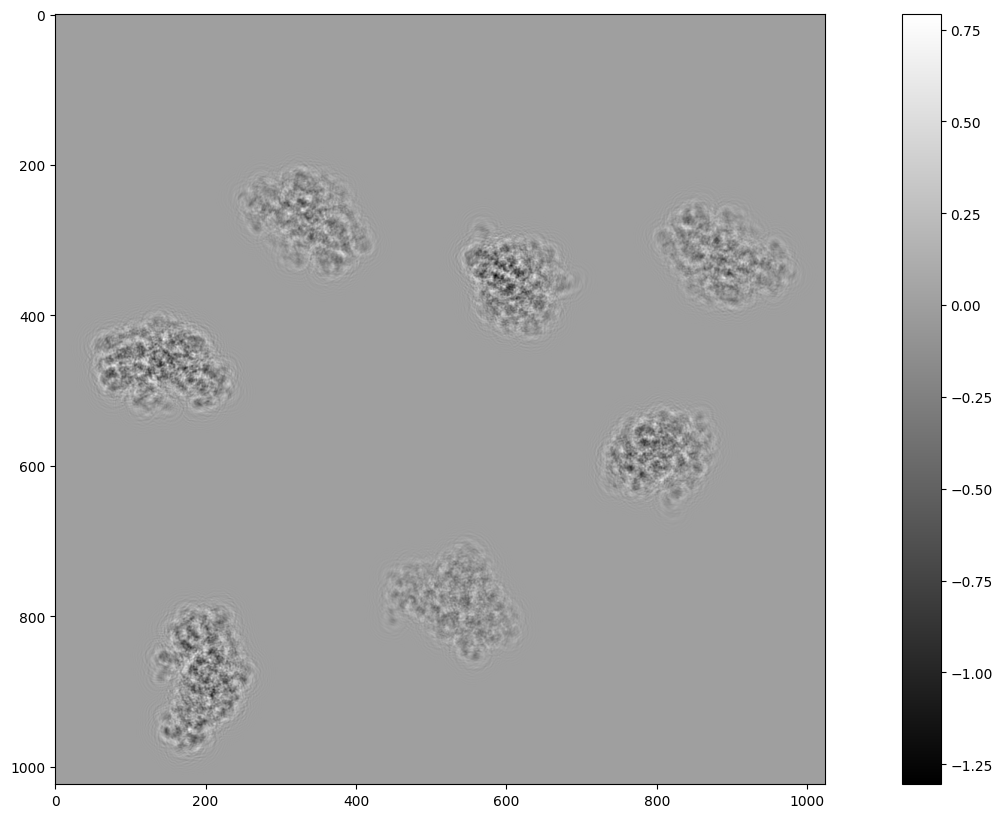

In [10]:
from aspire.operators import RadialCTFFilter

# Create our CTF Filter and add it to a list.
# This configuration will apply the same CTF to all particles.
# ctfs = [
#     RadialCTFFilter(pixel_size=1.16, voltage=300, defocus=16500, Cs=2.7, alpha=0.03, B=0),
# ]


defocus_min = 0.7e4              # Minimum defocus value (in angstroms).
defocus_max = 2.6e4              # Maximum defocus value (in angstroms).
defocus_ct = n_micrographs
random_defocus_values = np.random.uniform(defocus_min, defocus_max, defocus_ct)
# Create filters
ctfs = [RadialCTFFilter(pixel_size=1.16, voltage=300, defocus=d, Cs=2.0, alpha=0.1)
        for d in random_defocus_values]

src = MicrographSimulation(
    vol,
    particles_per_micrograph=n_particles_per_micrograph,
    micrograph_size=1024,
    micrograph_count=n_micrographs,
    ctf_filters=ctfs,
    seed=1234,
)

# Plot the micrographs
#src.images[:].show()

## Noise
By default, no noise corruption is configured.
To apply noise, pass a ``NoiseAdder`` to ``MicrographSimulation``.



2024-04-20 14:36:02,454 INFO [aspire.source.image] Creating Simulation with 9 images.


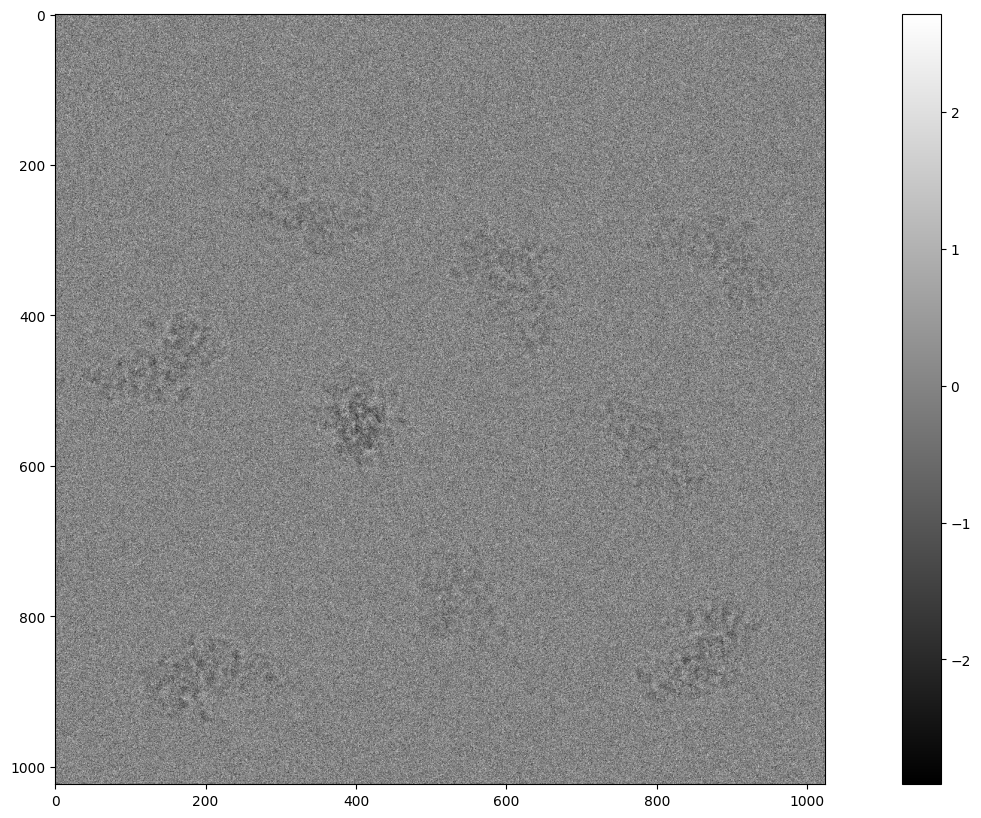

In [11]:
from aspire.noise import WhiteNoiseAdder

# # Create our noise using WhiteNoiseAdder
noise = WhiteNoiseAdder(3.5e-1, seed=1234)
n_particles_per_micrograph=9
# # Add noise to our MicrographSimulation using the noise_adder argument
src = MicrographSimulation(
    vol,
    noise_adder=noise,
    particles_per_micrograph=n_particles_per_micrograph,
    micrograph_size=1024,
    micrograph_count=1,
    ctf_filters=ctfs,
    seed=1234,
)

# Plot the micrographs
#src.images[:].show()

Plot the clean micrographs using the ``clean_images`` accessor.



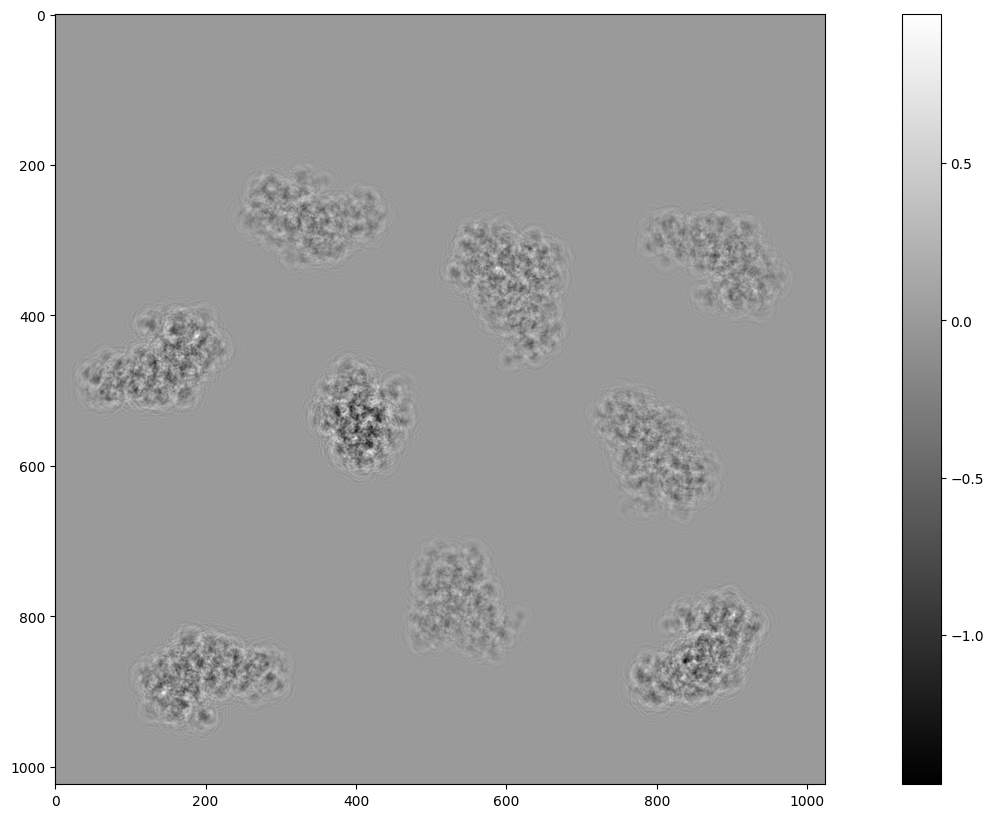

In [ ]:
src.clean_images[:].show()

## Interparticle Distance
By default, particle distance is set to avoid collisions.
We can use the ``interparticle_distance`` argument to control the
minimum distance between particle centers.
However, setting this argument too large may generate insufficient centers.



In [13]:
# Let's increase the number of particles to show overlap.
n_particles_per_micrograph = 12

# Set the interparticle distance to 1, which adds at least one pixel
# of separation between center and allows particles to collide.
src = MicrographSimulation(
    vol,
    interparticle_distance=200,
    noise_adder=noise,
    particles_per_micrograph=n_particles_per_micrograph,
    micrograph_size=1024,
    micrograph_count=n_micrographs,
    ctf_filters=ctfs,
)

# Plot the micrographs
#src.images[:].show()

2024-04-20 14:36:44,934 INFO [aspire.source.image] Creating Simulation with 12 images.


## Boundary
By default, the boundary is set to half of the particle width,
which will completely contain every particle inside the micrograph.
Setting ``boundary=0`` will allow particles to be placed along the edges.
Positive values (measured in pixels) move the boundaries inward,
while negative values move the boundaries outward.



In [ ]:
import mrcfile
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# 載入 MRC 文件
mrc_path = '/content/drive/MyDrive/aspire/noise1024mrc/1024/micrograph_0.mrc'
with mrcfile.open(mrc_path, permissive=True) as mrc:
    # 獲取 MRC 數據
    mrc_data = mrc.data
print(mrc_data.shape)
# 保存為 JPEG
jpg_path = '/content/drive/MyDrive/aspire/aspire_noise_1024.jpg'
# Normalize data to 0-255 range
normalized_data = ((mrc_data - mrc_data.min()) / (mrc_data.max() - mrc_data.min()) * 255).astype(np.uint8)
# Save as JPEG
plt.imsave(jpg_path, normalized_data[0], cmap='gray', format='jpeg')

# 顯示原始 MRC 圖像
plt.figure(figsize=(10, 10))
plt.imshow(mrc_data[0], cmap='gray')
plt.title('原始 MRC 圖像')
plt.show()

# 顯示保存的 JPEG 圖像
plt.figure(figsize=(10, 10))
jpg_data = plt.imread(jpg_path)
plt.imshow(jpg_data, cmap='gray')
plt.title('保存的 JPEG 圖像')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


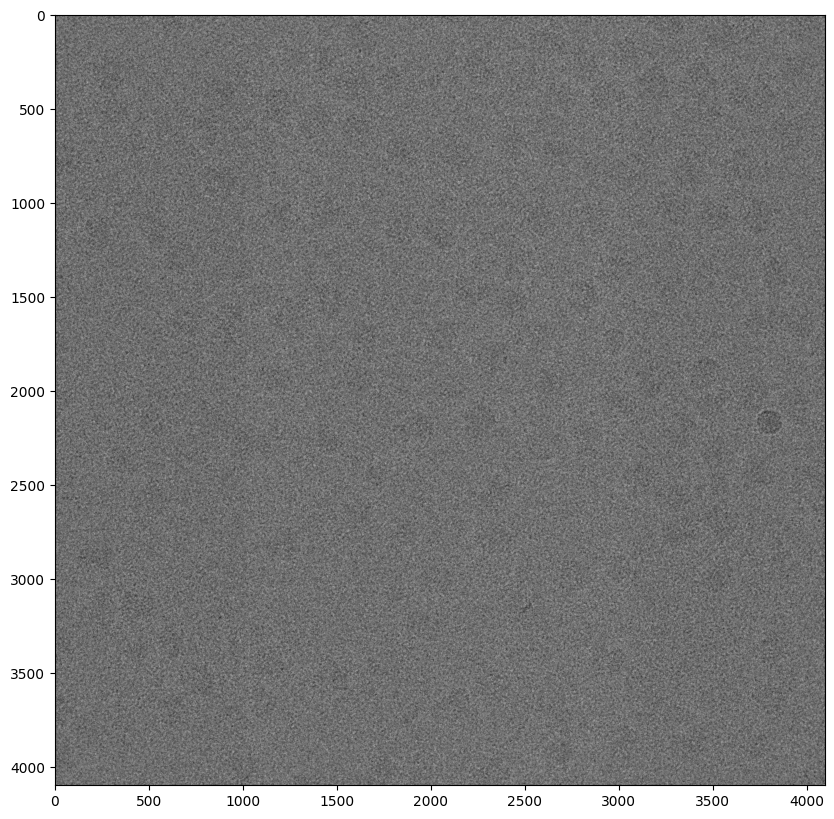

In [ ]:
import mrcfile
import matplotlib.pyplot as plt

# 載入 MRC 文件
mrc_path = '/content/drive/MyDrive/NT2C/tiff/10077_raw/sb1_210512 pos 5 1-1_1.mrc'
with mrcfile.open(mrc_path, permissive=True) as mrc:
    # 獲取 MRC 數據
    mrc_data = mrc.data

plt.figure(figsize=(10,10))
plt.imshow(mrc_data[ :, :], cmap='gray')  # 這裡的 [0, :, :] 表示取第一個 slice，你可以根據需要更改
plt.show()

In [14]:
# Create a micrograph with a negative boundary, allowing particles to
# generate outward.
start_time = time.time()
noise = WhiteNoiseAdder(1, seed=1234)
out_src = MicrographSimulation(
    vol,
    boundary=-20,
    interparticle_distance=180,
    noise_adder=noise,
    particles_per_micrograph=220,
    micrograph_size=4096,
    micrograph_count=1,
    ctf_filters=ctfs,
    seed=1234
)
execution_time = time.time() - start_time

# 輸出執行時間
print("程式碼執行時間為：", execution_time, "秒")

# Plot the micrographs
#out_src.images[:].show()

2024-04-20 14:37:03,668 INFO [aspire.source.image] Creating Simulation with 220 images.
程式碼執行時間為： 49.343939542770386 秒


In [17]:
start_time = time.time()
out_src = MicrographSimulation(
    vol,
    boundary=-20,
    interparticle_distance=180,
    noise_adder=noise,
    particles_per_micrograph=220,
    micrograph_size=4096,
    micrograph_count=2,
    ctf_filters=ctfs,
    seed=1234
)
#out_src.images[:].show()
results = out_src.save(os.path.join('/content/drive/MyDrive/aspire/test', "4096"))
execution_time = time.time() - start_time

# 輸出執行時間
print("程式碼執行時間為：", execution_time, "秒")

2024-04-20 14:47:05,585 INFO [aspire.source.image] Creating Simulation with 440 images.
2024-04-20 14:51:54,346 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-04-20 14:51:54,395 INFO [aspire.storage.starfile] Created StarFile with blocks: 
程式碼執行時間為： 288.828022480011 秒


In [ ]:
out_src_clean = MicrographSimulation(
    vol,
    boundary=-20,
    interparticle_distance=180,
    #noise_adder=noise,
    particles_per_micrograph=220,
    micrograph_size=4096,
    micrograph_count=150,
    ctf_filters=ctfs,
    seed=1234
)


2024-03-03 03:31:23,137 INFO [aspire.source.image] Creating Simulation with 33000 images.


In [ ]:
out_src_clean = MicrographSimulation(
    vol,
    boundary=-20,
    interparticle_distance=180,
    #noise_adder=noise,
    particles_per_micrograph=13,
    micrograph_size=1024,
    micrograph_count=1,
    ctf_filters=ctfs,
    seed=1234
)
results2 = out_src_clean.save(os.path.join('/content/drive/MyDrive/aspire/clean1024mrc', "1024"))

2024-03-10 14:43:55,924 INFO [aspire.source.image] Creating Simulation with 13 images.
2024-03-10 14:43:59,550 INFO [aspire.storage.starfile] Created StarFile with blocks: 


## Particle Indices
Each particle comes from a ``Simulation`` internal to
``MicrographSimulation``.  This simulation can be accessed directly
by the attribute ``MicrographSimulation.simulation``.  A map is
provided between each particle's indexing relative to that
``Simulation`` and micrograph based indexing.  This relationship is
demonstrated below.



In [ ]:
# Let's choose four random numbers as our global (``Simulation``)
# particle indices from ``test_micrograph=1``.
test_micrograph = 1
n_particles = 3
local_particle_indices = np.random.choice(n_particles_per_micrograph, n_particles)
print(f"Local particle indices: {local_particle_indices}")

Local particle indices: [ 5 11  3]


We can obtain the individual particle images from our
``MicrographSimulation`` by retrieving their centers and plotting
the boundary boxes.



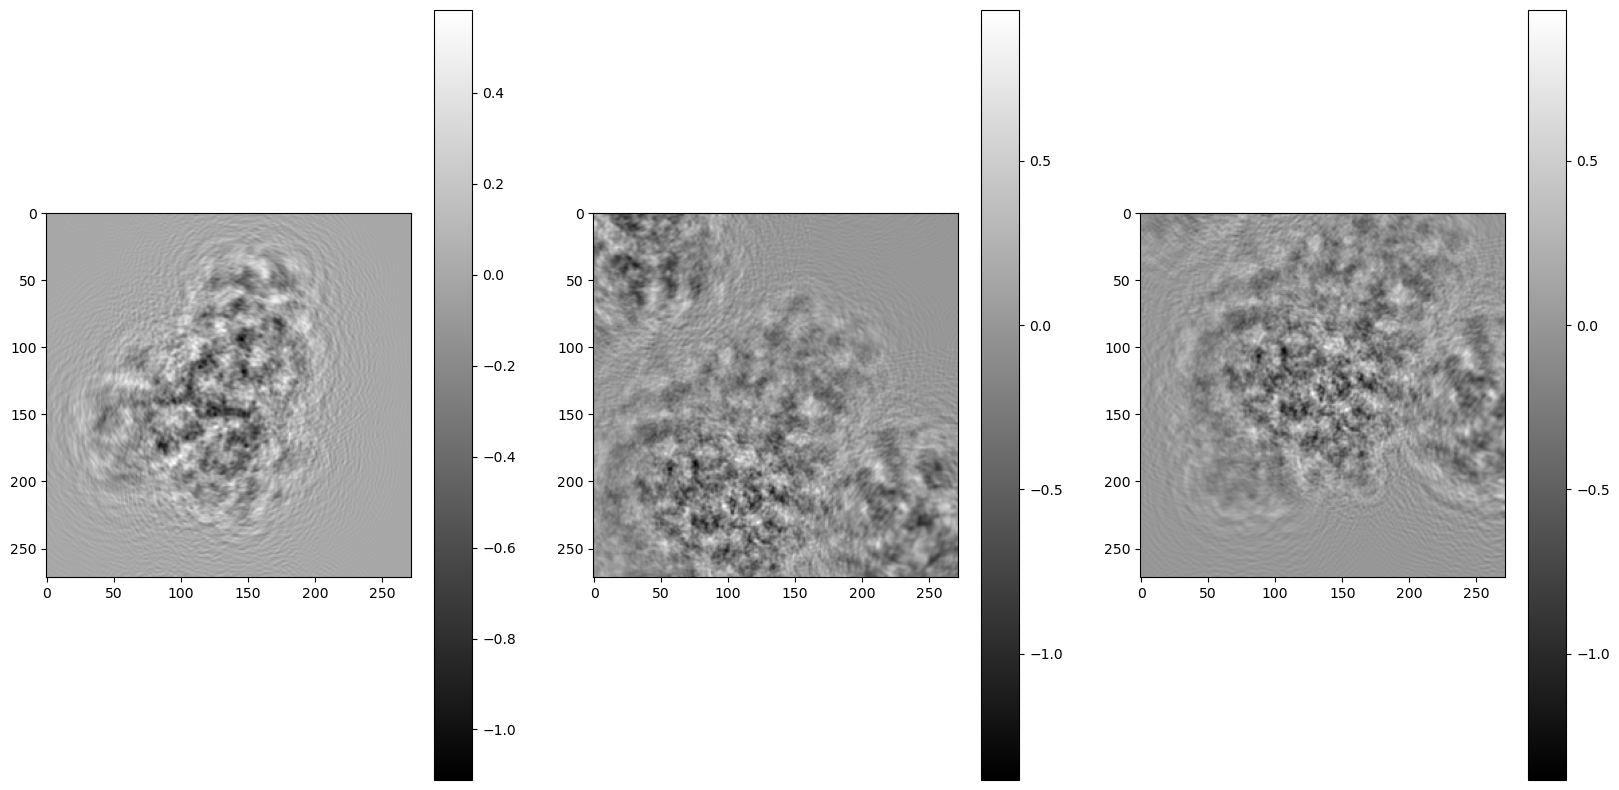

In [ ]:
centers = np.zeros((n_particles, 2), dtype=int)
for i in range(n_particles):
    centers[i] = src.centers[test_micrograph][local_particle_indices[i]]

# Let's use the particles' centers and sizes to perform "perfect
# particle picking" on this test micrograph.
p_size = src.particle_box_size
micrograph_picked_particles = np.zeros(
    (
        n_particles,
        src.particle_box_size,
        src.particle_box_size,
    )
)

for i, center in enumerate(centers):
    x, y = center[0], center[1]
    # Calculate the square of the particle
    particle = src.clean_images[test_micrograph].asnumpy()[0][
        x - p_size // 2 : x + p_size // 2, y - p_size // 2 : y + p_size // 2
    ]
    micrograph_picked_particles[i] = particle

# Let's plot and look at the particles!
from aspire.image import Image

Image(micrograph_picked_particles)[:].show()

<div class="alert alert-info"><h4>Note</h4><p>There may be overlap with nearby particles in the above images.
    To reduce overlap, increase ``interparticle_distance``.</p></div>



Let's find the images from the ``Simulation`` using the
``get_particle_indices`` method to retrieve their global indices.



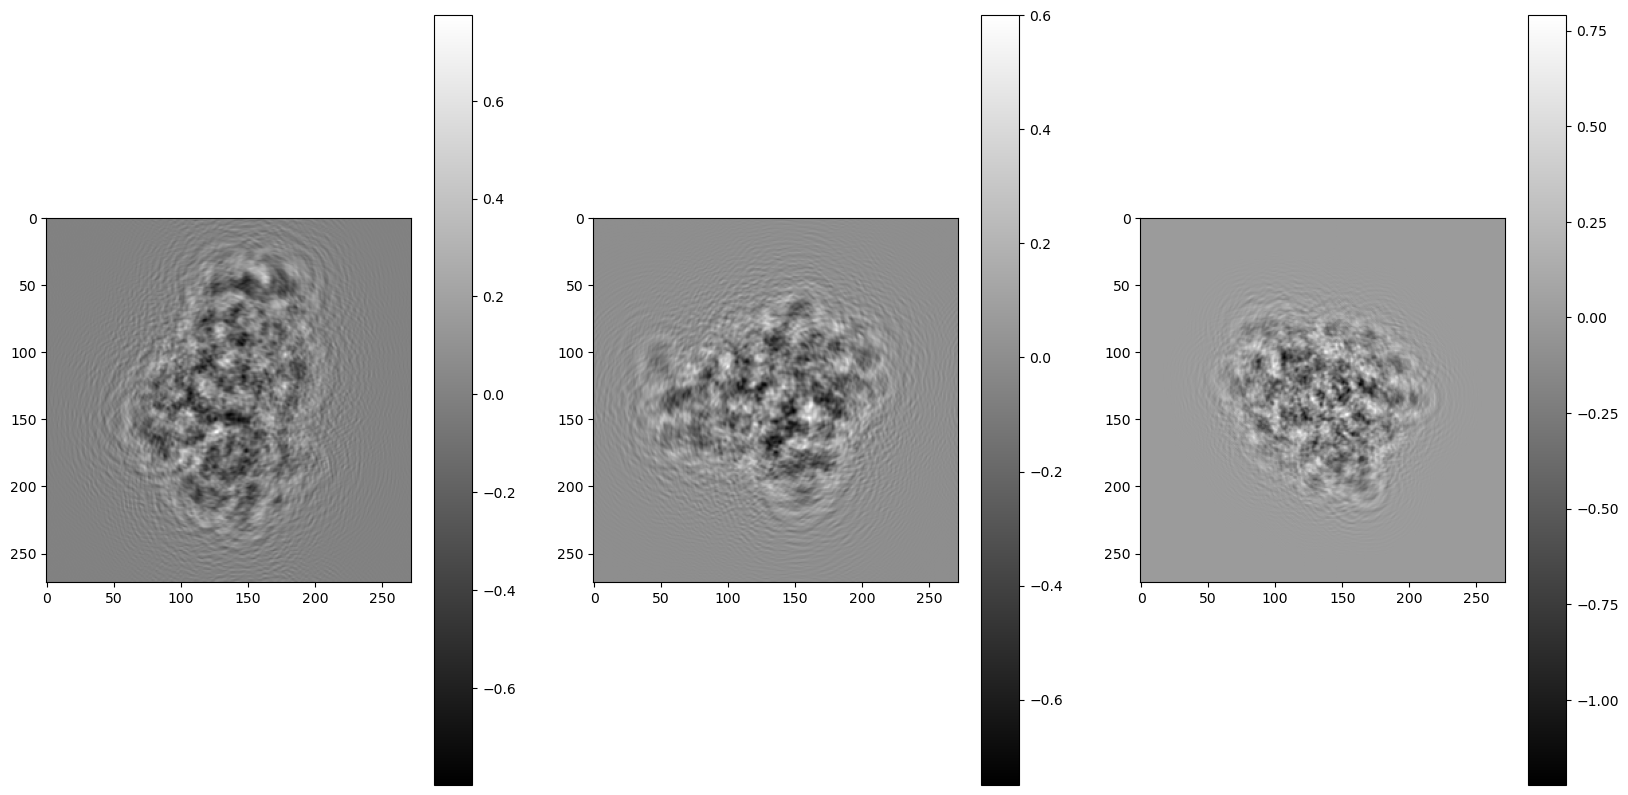

In [ ]:
global_particle_indices = np.zeros((n_particles), dtype=int)
for i in range(n_particles):
    global_particle_indices[i] = src.get_particle_indices(
        test_micrograph, local_particle_indices[i]
    )

# Plot the simulation's images
src.simulation.images[global_particle_indices].show()

We can check if these global indices match our local particle
indices with the ``get_micrograph_index`` method.



In [ ]:
check_local_indices = np.zeros((n_particles), dtype=int)
for i in range(n_particles):
    # Get each particle's corresponding micrograph index and local particle index
    micrograph_index, check_local_indices[i] = src.get_micrograph_index(
        global_particle_indices[i]
    )
    assert micrograph_index == 1
np.testing.assert_array_equal(local_particle_indices, check_local_indices)
print(f"Local particle indices: {check_local_indices}")

Local particle indices: [ 5 11  3]


## Saving a MicrographSimulation
In addition to saving the raw MRC files, ``MicrographSimulation``
populates STAR files with the particle centers, particle box size
(``rlnImageSize``), and projection rotations.  Additionally, CTF
parameters are saved when CTF is used in the simulation.  Each
micrograph will have a corresponidng STAR file.  The collection of
these files are returned from ``MicrographSimulation.save`` as a
list of tuples which is designed to work directly with
``CentersCoordinateSource``.



In [ ]:
tmp_dir = tempfile.TemporaryDirectory()

In [ ]:
from aspire.source import CentersCoordinateSource

# Save the simulation
results = src.save(os.path.join(tmp_dir.name, "mg_sim"))

2024-02-28 16:05:57,911 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,912 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,913 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,914 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,915 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,916 INFO [aspire.storage.starfile] Created StarFile with blocks: 


In [ ]:
# Review the resulting files
print(results)

[('/tmp/tmpaiq9wx6g/mg_sim/micrograph_0.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_0.star'), ('/tmp/tmpaiq9wx6g/mg_sim/micrograph_1.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_1.star'), ('/tmp/tmpaiq9wx6g/mg_sim/micrograph_2.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_2.star'), ('/tmp/tmpaiq9wx6g/mg_sim/micrograph_3.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_3.star'), ('/tmp/tmpaiq9wx6g/mg_sim/micrograph_4.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_4.star'), ('/tmp/tmpaiq9wx6g/mg_sim/micrograph_5.mrc', '/tmp/tmpaiq9wx6g/mg_sim/micrograph_5.star')]


In [ ]:
# Review the example STAR file contents
with open(results[0][1], "r") as f:
    print(f.read())

data_
loop_
_rlnImageName
_rlnImageSize
_rlnCoordinateX
_rlnCoordinateY
_rlnAngleRot
_rlnAngleTilt
_rlnAnglePsi
_rlnVoltage
_rlnDefocusU
_rlnDefocusV
_rlnDefocusAngle
_rlnSphericalAberration
_rlnAmplitudeContrast
000001@micrograph_0 272 705 289 144.8269857989603 82.26178407407484 99.14175240393509 300.0 15327.149588792465 15327.149588792465 0.0 2.0 0.1
000002@micrograph_0 272 211 799 292.93383410306154 163.66310556037507 226.90488939831909 300.0 19916.18477334982 19916.18477334982 0.0 2.0 0.1
000003@micrograph_0 272 842 692 81.40099014274185 86.00015894942015 123.4749640801909 300.0 24260.360027873034 24260.360027873034 0.0 2.0 0.1
000004@micrograph_0 272 491 814 297.67853198481697 53.632769864924875 165.85796131769706 300.0 8650.494780047213 8650.494780047213 0.0 2.0 0.1
000005@micrograph_0 272 237 689 178.16223099944753 46.48008178086393 64.03386102834286 300.0 21415.969098298418 21415.969098298418 0.0 2.0 0.1
000006@micrograph_0 272 461 724 215.47424342323802 46.49231715322363 318.9

2024-02-28 16:05:57,935 INFO [aspire.storage.starfile] Parsing star file at: /tmp/tmpaiq9wx6g/mg_sim/micrograph_0.star
2024-02-28 16:05:57,936 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,937 INFO [aspire.storage.starfile] Parsing star file at: /tmp/tmpaiq9wx6g/mg_sim/micrograph_1.star
2024-02-28 16:05:57,937 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,938 INFO [aspire.storage.starfile] Parsing star file at: /tmp/tmpaiq9wx6g/mg_sim/micrograph_2.star
2024-02-28 16:05:57,939 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,939 INFO [aspire.storage.starfile] Parsing star file at: /tmp/tmpaiq9wx6g/mg_sim/micrograph_3.star
2024-02-28 16:05:57,940 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-02-28 16:05:57,941 INFO [aspire.storage.starfile] Parsing star file at: /tmp/tmpaiq9wx6g/mg_sim/micrograph_4.star
2024-02-28 16:05:57,942 INFO [aspire.storage.starfile] Create

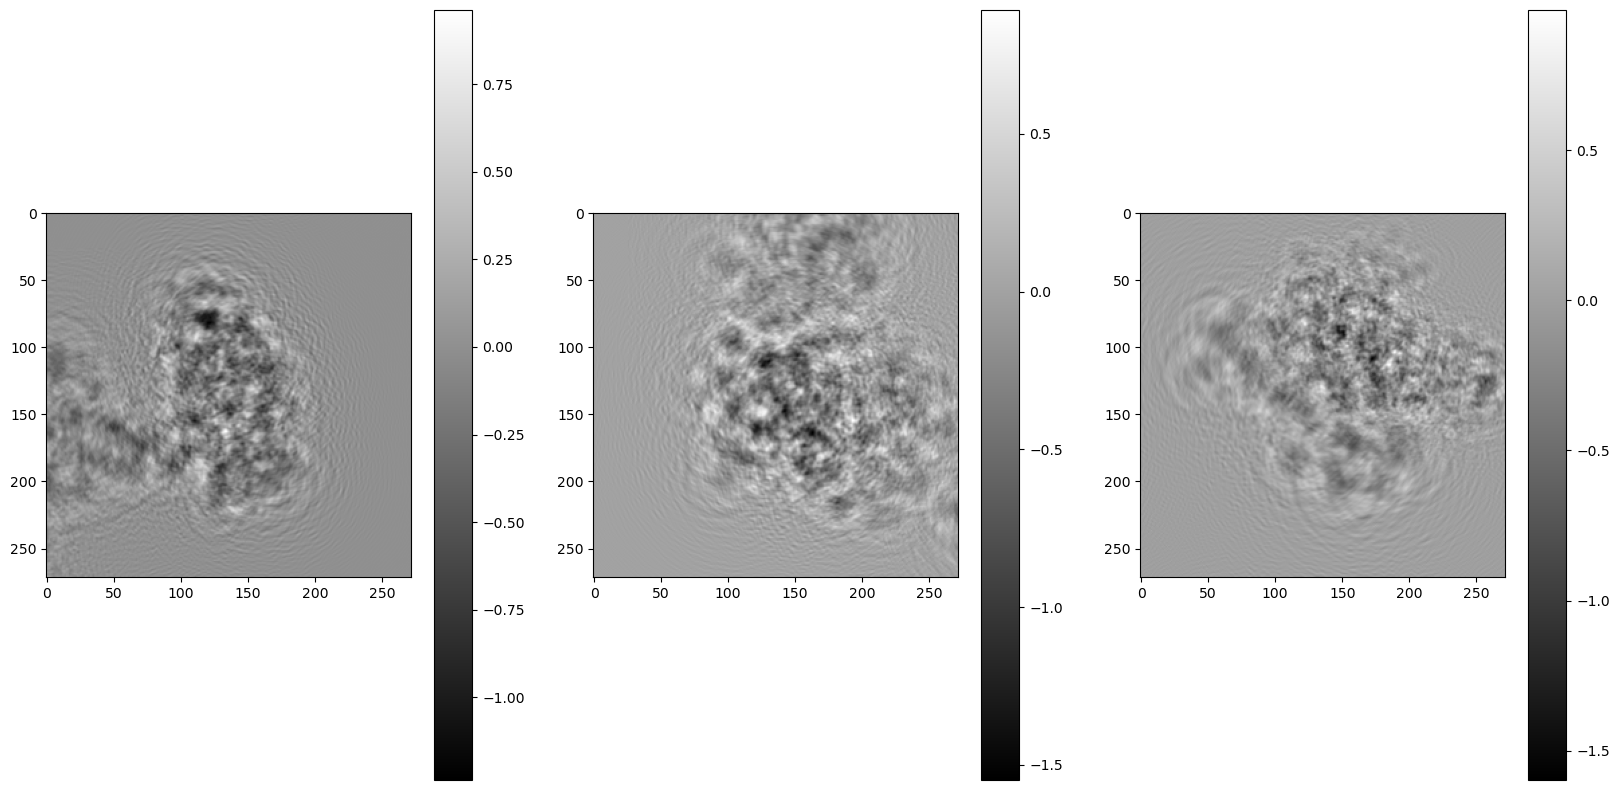

In [ ]:
img_src = CentersCoordinateSource(results, src.particle_box_size)
# Show the first five images from the image source.
img_src.images[:3].show()

# Cleanup the tmp_dir
tmp_dir.cleanup()